In [1]:
import sys
sys.path.append('..')
import re
import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from skimage import io, img_as_ubyte
import json

import torch
import torch.nn.functional as F

import seaborn as sns
sns.set()

from models import get_net
from utils.denoising_utils import *
from utils.common_utils import np_to_pil, pil_to_np, get_fname

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [2]:
def get_trained_net(net_info, train_data):
    bay_inf_type = net_info['bay_inf_type']
    
    net = get_net(net_info['num_input_channels'], 'skip', 'reflection',
              skip_n33d=net_info['num_channels_down'],
              skip_n33u=net_info['num_channels_up'],
              skip_n11=net_info['num_channels_skip'],
              num_scales=net_info['num_scales'],
              n_channels=net_info['num_output_channels'],
              upsample_mode=net_info['upsample_mode'],
              need_sigmoid=False)

    #optimizer = torch.optim.AdamW(net.parameters(), lr=net_info['lr'])
    
    if bay_inf_type == 'mc_dropout':
        net = MCDropoutVI(net, net_info['dropout_type'], net_info['dropout_p'])
    elif bay_inf_type == 'mean_field':
        prior = {'mu': net_info['prior_mu'], 'sigma': net_info['prior_sigma']}
        if net_info['prior_pi'] is not None:
            prior['pi'] = net_info['prior_pi']
        net = MeanFieldVI(net, prior=prior, kl_type=net_info['kl_type'])
    
    net.load_state_dict(train_data['state_dict'])
    return net.type(dtype)

In [21]:
path_log_dir = '/media/fastdata/toelle/logs'
mc_iter = 25

img_name = 'ct'
regexp = "%s\_[0-9][0-9]\_[0-9][0-9]\_[0-9][0-9][0-9][0-9]\_[0-9][0-9]\_[0-9][0-9]\_[0-9][0-9]" % img_name

runs = [run for run in os.listdir(path_log_dir) if bool(re.search(regexp, run))]

if img_name == 'xray':
    runs += ['mc_dropout_den_xray_2d_sigma_002', 'mc_dropout_den_xray_2d_sigma_005', 'mc_dropout_den_xray_2d_sigma_0075',
             'mc_dropout_den_xray_2d_1', 'mc_dropout_den_xray_2d_sigma_015']
    runs += ['mean_field_den_xray_sigma_002', 'mean_field_den_xray_sigma_005', 'mean_field_den_xray_sigma_0075',
            'mean_field_den_xray_1e-6_reverse_2', 'mean_field_den_xray_sigma_015']

losses = {'none': {}, 'mean\_field': {}, 'mc\_dropout': {}, 'sgld': {}, 'sgld\_paper': {}}
psnrs_gt = {'none': {}, 'mean\_field': {}, 'mc\_dropout': {}, 'sgld': {}, 'sgld\_paper': {}}
psnrs_noisy = {'none': {}, 'mean\_field': {}, 'mc\_dropout': {}, 'sgld': {}, 'sgld\_paper': {}}
uncerts = {'none': {}, 'mean\_field': {}, 'mc\_dropout': {}, 'sgld': {}, 'sgld\_paper': {}}
uces = {'none': {}, 'mean\_field': {}, 'mc\_dropout': {}, 'sgld': {}, 'sgld\_paper': {}}

for run in runs:
    label = run.split('_')[:2]
    if label[1] == 'den':
        label = label[0]
    else:
        label = '\_'.join(label)
    net_info = json.load(open('%s/%s/net_info.json' % (path_log_dir, run)))
    if label == 'mc_dropout' and net_info['dropout_type'] == 'g2d':
        continue
    train_data = torch.load('%s/%s/train_vals.pt' % (path_log_dir, run), map_location='cpu')
    try:
        image_data = np.load('%s/%s/vals.npz' % (path_log_dir, run))
        sigma = image_data['sigma'].tolist()
    except:
        sigma = float(run.split('_')[-1]) * 0.001
    losses[label][sigma] = np.array(train_data['mse'][-200:]).mean()
    psnrs_gt[label][sigma] = np.array(train_data['psnr_gt_sm'][-200:]).mean()
    psnrs_noisy[label][sigma] = np.array(train_data['psnr_noisy'][-200:]).mean()
    
    net_input_np = image_data['net_input']
    net_input = torch.from_numpy(net_input_np).type(dtype)
    img_np_noisy = pil_to_np(Image.open('%s/%s/noisy_img.png' % (path_log_dir, run)))
    img_noisy_torch = torch.from_numpy(img_np_noisy).unsqueeze(0).type(dtype)
    net = get_trained_net(net_info, train_data)
    
    if net_info['bay_inf_type'] in ['sgld', 'sgld_paper']:
        samples = [pil_to_np(Image.open('%s/%s/%s' % (path_log_dir, run, fname))) for fname in os.listdir('%s/%s' % (path_log_dir, run)) if fname[:6] == 'sample']
        
        uncert = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
        
        uncerts[label][sigma] = np.mean(uncert)

        uncert = torch.from_numpy(uncert).unsqueeze(0).unsqueeze(0)

        mean = np.mean(np.array(samples)[:,:-1], axis=0)
        out_torch_mean = torch.from_numpy(mean).unsqueeze(0)

        mse_err = F.mse_loss(out_torch_mean, img_noisy_torch.cpu(), reduction='none')
        mse_err = mse_err.mean(dim=1, keepdim=True)

        uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)
        
        uces[label][sigma] = uce.item()
        
    elif net_info['bay_inf_type'] in ['mc_dropout', 'mean_field']:
        img_list = []

        with torch.no_grad():
            for _ in range(mc_iter):
                img = net(net_input)
                img[:,:-1] = img[:,:-1].sigmoid()
                img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
                img_list.append(img)
        
        ale, epi, uncert = uncert_regression_gal(img_list, reduction='none')
        
        

        out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)

        mse_err = F.mse_loss(out_torch_mean[:,:-1], img_noisy_torch, reduction='none')
        mse_err = mse_err.mean(dim=1, keepdim=True)

        uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)
        
        uncert_mean = torch.mean(uncert).item()
        if uncert_mean > 100 * sigma:
            uncert_mean, uce = None, None
        else:
            uce = uce.item()
        
        uncerts[label][sigma] = uncert_mean
        uces[label][sigma] = uce

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


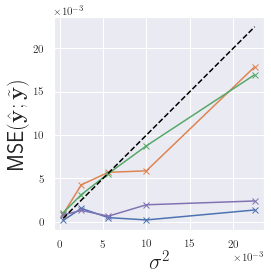

In [22]:
handles, labels = [], []

fig, ax = plt.subplots()
for inf_type, _losses in losses.items():
    keys, vals = np.array(list(_losses.keys()))**2, np.array(list(_losses.values()))
    idx = np.argsort(keys)
    plot = ax.plot(keys[idx], vals[idx], label=inf_type, marker='x')
    handles.append(plot[0])
    labels.append(inf_type)
ax.plot([0.02**2, 0.15**2], [0.02**2, 0.15**2], color='black', linestyle='--')
ax.set_ylabel(r'MSE$(\hat{\mathbf{y}};\tilde{\mathbf{y}})$', fontsize=22)
ax.set_xlabel(r'$\sigma^2$', fontsize=22)
#ax.legend()
ax.set_aspect(1)
ticks = np.arange(0., 0.025, 0.005)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.tight_layout()
plt.savefig('noise_levels_mses_%s.pdf' % img_name, bbox_inches='tight')
plt.show()

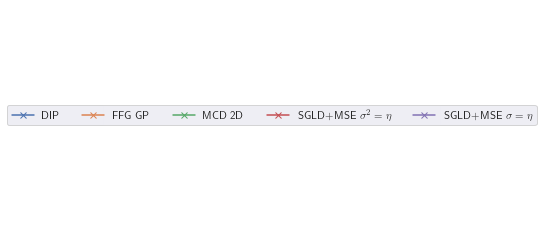

In [23]:
_labels = [r'DIP', r'FFG GP', r'MCD 2D', r'SGLD+MSE $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$']
fig_l, ax_l = plt.subplots(1, 1)
legend = ax_l.legend(handles, _labels, loc='center', ncol=5)
ax_l.grid(False)
ax_l.set_yticks([])
ax_l.set_xticks([])
ax_l.set_facecolor((1., 1., 1.))
fig_l  = legend.figure
fig_l.canvas.draw()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array([-5,-5,5,5])))
bbox = bbox.transformed(fig_l.dpi_scale_trans.inverted())
fig_l.savefig('%s_noise_levels_legend.pdf' % img_name, dpi="figure", bbox_inches=bbox)
plt.show()

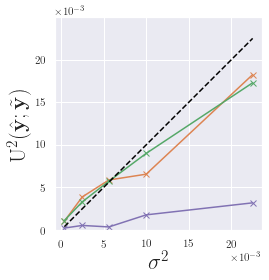

In [24]:
fig, ax = plt.subplots()
for inf_type, _uncerts in uncerts.items():
    keys, vals = np.array(list(_uncerts.keys()))**2, np.array(list(_uncerts.values()))
    idx = np.argsort(keys)
    ax.plot(keys[idx], vals[idx], label=inf_type, marker='x')
ax.plot([0.02**2, 0.15**2], [0.02**2, 0.15**2], color='black', linestyle='--')
ax.set_ylabel(r'$\mathrm{U}^2(\hat{\mathbf{y}};\tilde{\mathbf{y}})$', fontsize=22)
ax.set_xlabel(r'$\sigma^2$', fontsize=22)
#ax.legend()
ax.set_aspect(1)
ticks = np.arange(0., 0.025, 0.005)
ax.set_ylim([0,0.025])
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.tight_layout()
plt.savefig('noise_levels_uncerts_%s.pdf' % img_name, bbox_inches='tight')
plt.show()

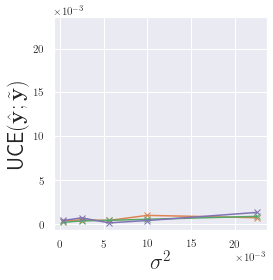

In [25]:
fig, ax = plt.subplots()
for inf_type, _uces in uces.items():
    keys, vals = np.array(list(_uces.keys()))**2, np.array(list(_uces.values()))
    idx = np.argsort(keys)
    ax.plot(keys[idx], vals[idx], label=inf_type, marker='x')

ax.set_ylabel(r'UCE$(\hat{\mathbf{y}};\tilde{\mathbf{y}})$', fontsize=22)
ax.set_xlabel(r'$\sigma^2$', fontsize=22)
#ax.legend()
ax.set_ylim(ax.get_xlim())
ax.set_aspect(1)
#ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))
ticks = np.arange(0., 0.025, 0.005)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.tight_layout()
plt.savefig('noise_levels_uces_%s.pdf' % img_name, bbox_inches='tight')
plt.show()

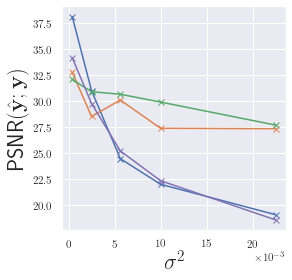

In [26]:
fig, ax = plt.subplots()
for inf_type, _psnrs in psnrs_gt.items():
    keys, vals = np.array(list(_psnrs.keys()))**2, np.array(list(_psnrs.values()))
    idx = np.argsort(keys)
    ax.plot(keys[idx], vals[idx], label=inf_type, marker='x')
ax.set_ylabel(r'PSNR$(\hat{\mathbf{y}};\mathbf{y})$', fontsize=22)
ax.set_xlabel(r'$\sigma^2$', fontsize=22)
#ax.legend()
ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.tight_layout()
plt.savefig('noise_levels_psnrs_gt_%s.pdf' % img_name, bbox_inches='tight')
plt.show()

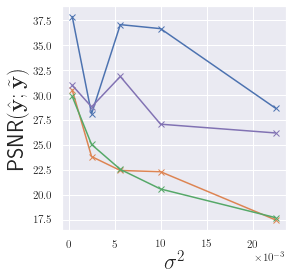

In [27]:
fig, ax = plt.subplots()
for inf_type, _psnrs in psnrs_noisy.items():
    keys, vals = np.array(list(_psnrs.keys()))**2, np.array(list(_psnrs.values()))
    idx = np.argsort(keys)
    ax.plot(keys[idx], vals[idx], label=inf_type, marker='x')
ax.set_ylabel(r'PSNR$(\hat{\mathbf{y}};\tilde{\mathbf{y}})$', fontsize=22)
ax.set_xlabel(r'$\sigma^2$', fontsize=22)
#ax.legend()
ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
plt.tight_layout()
#plt.savefig('noise_levels_psnrs_noisy_%s.pdf' % img_name, bbox_inches='tight')
plt.show()